Best Parameters:  {'max_depth': 20, 'n_estimators': 100}
Best Accuracy on Entire Dataset:  0.9343706474013949
Feature Importance:
                                             Feature  Importance
1                   prev_host_is_superhost_in_period    0.270409
3                           prev_rating_ave_pastYear    0.110298
7                   prev_prop_5_StarReviews_pastYear    0.079841
6                       prev_num_5_star_Rev_pastYear    0.056889
5                            prev_numCancel_pastYear    0.051849
18                            prev_Number of Reviews    0.046365
19                               prev_Rating Overall    0.043691
4                           prev_numReviews_pastYear    0.040961
11                 prev_hostResponseAverage_pastYear    0.031907
9                            prev_numReserv_pastYear    0.029584
8                      prev_numReservedDays_pastYear    0.027991
10                  prev_hostResponseNumber_pastYear    0.022096
20                       

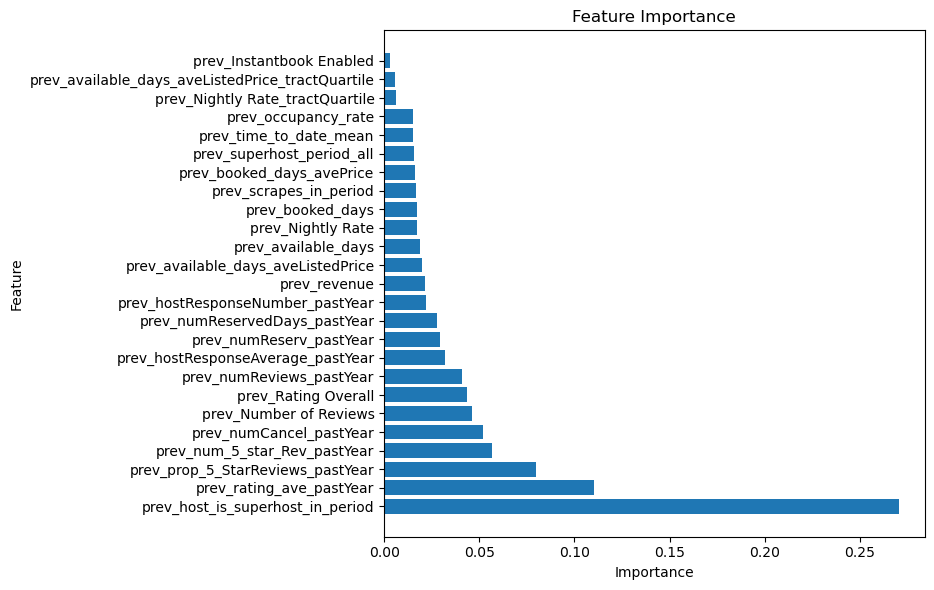

In [12]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
import seaborn as sns

# Load your dataset
df = pd.read_csv("airbnb_Oakland.csv")

# Use regular expression to filter column names. Use only the previous year predictor that starts with prev_
pattern = re.compile(r'^prev_')
prev_year_features = [col for col in df.columns if pattern.match(col)]

# Remove the specified features from the list of previous year features
features_to_remove = ['prev_host_is_superhost', 'prev_host_is_superhost1', 'prev_host_is_superhost2', 'prev_year_superhosts']
prev_year_features = [col for col in prev_year_features if col not in features_to_remove]

# Extract features and target variable
X = df[prev_year_features]
y = df["host_is_superhost_in_period"]

# Create a SimpleImputer to handle missing values (replace NaN with the mean, for example)
imputer = SimpleImputer(strategy='mean')  # You can choose 'mean', 'median', 'most_frequent', or a constant value

# Fit the imputer on the entire dataset and transform
X_imputed = imputer.fit_transform(X)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

# Create a Random Forest classifier
clf = RandomForestClassifier()

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 150],
    'max_depth': [10, 20],
}

# Perform GridSearchCV
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='accuracy', cv=5)
grid_search.fit(X_train, y_train)

# Print the best parameters and the corresponding accuracy on the entire dataset
print("Best Parameters: ", grid_search.best_params_)
print("Best Accuracy on Entire Dataset: ", grid_search.best_score_)

# Make predictions on the imputed testing data
y_pred = grid_search.predict(X_test)

# Feature Importance
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': prev_year_features, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print the feature importances
print("Feature Importance:")
print(feature_importance_df)

# Print the classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Plot the feature importances and the confusion matrix side by side
plt.figure(figsize=(15, 6))

# Feature Importance Plot
plt.subplot(1, 2, 1)
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')

# Prediction in current year features
# Remove "prev_" from the column names to get the present year features
present_year_features = [col.replace("prev_", "") for col in prev_year_features]

# Extract features for the new dataset (next year's data) and handle feature name mismatches
X_new = df[present_year_features]
X_new = X_new.rename(columns=dict(zip(X_new.columns, prev_year_features)))

# Impute missing values using the same imputer that was fitted on the training data
X_new_imputed = imputer.transform(X_new)

# Make predictions on the new imputed data
y_new_pred = grid_search.predict(X_new_imputed)

# Print the predicted values
print("\nPredicted Superhost Status for Next Year:")
print(y_new_pred)

# Append y_new_pred to the original dataframe as Predicted_Future_Superhost_Status
df['Predicted_Future_Superhost_Status'] = y_new_pred

# Save the dataframe with predictions to a new CSV file
df.to_csv("airbnb_Oakland_Predicted_Superhost.csv", index=False)

plt.tight_layout()
plt.show()